In [1]:
import os
import numpy as np
import music21 as m21
import pandas as pd
import json
import matplotlib.pyplot as plt
from scipy import stats
from scipy import spatial
from scipy import interp
import time
from collections import Counter
import math
from sklearn.metrics import roc_curve, auc, precision_recall_curve, confusion_matrix
from sklearn.preprocessing import label_binarize
from itertools import cycle

np.random.seed(777)

DIV_CONST = 64
TYPE_SCALE = 2
# 0: 0 - 0.5
# 1: 0.5 - 1
# 2: 0 - 1

# Functions

## Get Binary ROC values

In [2]:
def get_sim_after_threshold(input_sim_values, threshold_i):
    result_list_mod = []
    for sim_value_i in input_sim_values:
        if (sim_value_i >= threshold_i):
            result_list_mod.append(1)
        else:
            result_list_mod.append(0)
    return result_list_mod

In [20]:
def get_binary_ROC_values(scores_metric_and_experts_LOADED, flip_values=1.0, value_to_get=0, scale=0):
    raw_scorelist_sim_measure_BI = []
    raw_scorelist_sim_measure_majority_BI = []
    raw_scorelist_sim_exp_1_BI = []
    raw_scorelist_sim_exp_2_BI = []
    raw_scorelist_sim_exp_3_BI = []
    raw_scorelist_sim_exp_majority_BI = []
    
    flag_set = False
    max_value_seen = 0
    min_value_seen = 0
    
    for keyname_i in scores_metric_and_experts_LOADED.keys():
        for el in scores_metric_and_experts_LOADED[keyname_i]:
            
            sim_score = el[0]
            
            if (not flag_set):
                max_value_seen = sim_score
                min_value_seen = sim_score
                flag_set = True
            
            if (sim_score > max_value_seen):
                max_value_seen = sim_score
                
            if (sim_score < min_value_seen):
                min_value_seen = sim_score
    max_value_seen = max_value_seen * flip_values
    # print("++++++")
    # print(max_value_seen)
    for keyname_i in scores_metric_and_experts_LOADED.keys():
        for el in scores_metric_and_experts_LOADED[keyname_i]:
            
            
            sim_score = (el[0] * flip_values) / max_value_seen
            
            if (flip_values == -1.0):
                sim_score = 1.0 - sim_score
            
            # print(sim_score)
            exp_score_1 = el[1]
            exp_score_2 = el[2]
            exp_score_3 = el[3]
            
            raw_scorelist_sim_measure_BI.append(sim_score)
            raw_scorelist_sim_exp_1_BI.append(exp_score_1)
            raw_scorelist_sim_exp_2_BI.append(exp_score_2)
            raw_scorelist_sim_exp_3_BI.append(exp_score_3)

            # majority
            annotators_scores_count = dict(Counter([exp_score_1, exp_score_2, exp_score_3]))
            (max_count, max_value) = max([ (annotators_scores_count[keyname_ann], keyname_ann) for keyname_ann in annotators_scores_count ])
            
            # Majority
            # if max_count == 1:
            #    continue
            
            # Unanimity
            if max_count != 3:
                continue
            
            raw_scorelist_sim_exp_majority_BI.append(max_value)
            raw_scorelist_sim_measure_majority_BI.append(sim_score)
    
    
    mesured_results = None
    expert_results = None
    if (value_to_get == 0): # Return Majority Vote
        
        expert_results = raw_scorelist_sim_exp_majority_BI 
        mesured_results = raw_scorelist_sim_measure_majority_BI
        
        
    elif (value_to_get == 1): # Return Expert 1 Vote
        
        expert_results = raw_scorelist_sim_exp_1_BI 
        mesured_results = raw_scorelist_sim_measure_BI
        
    elif (value_to_get == 2): # Return Expert 2 Vote
        
        expert_results = raw_scorelist_sim_exp_2_BI
        mesured_results = raw_scorelist_sim_measure_BI
        
    elif (value_to_get == 3): # Return Expert 3 Vote
        
        expert_results = raw_scorelist_sim_exp_3_BI
        mesured_results = raw_scorelist_sim_measure_BI
    
    difference_in_results = {}
    
    for el_id in range(len(expert_results)):
        if expert_results[el_id] not in difference_in_results:
            difference_in_results[expert_results[el_id]] = []
        difference_in_results[expert_results[el_id]].append(np.abs(expert_results[el_id] - mesured_results[el_id]))
    
    difference_in_results["mean"] = np.array([])
    for key_value_exp_i in list(difference_in_results.keys()):
        difference_in_results[key_value_exp_i] = np.array(difference_in_results[key_value_exp_i])
        difference_in_results[key_value_exp_i] = np.mean(difference_in_results[key_value_exp_i])
        difference_in_results["mean"] = np.append(difference_in_results["mean"], difference_in_results[key_value_exp_i])
    difference_in_results["mean"] = np.mean(difference_in_results["mean"])
    return difference_in_results

# READ RESULTS

In [21]:
# Store for fpr, tpr, and auc
store_roc_values = {}

In [22]:
def print_score_results(store_roc_values_i):
    print(store_roc_values_i)

## RNA

In [23]:
scores_metric_and_experts_AlRyNo = []
with open('./ROC_AlRyNo/ROC_AlRyNo_1616808383.2642221.json') as json_file:
    scores_metric_and_experts_AlRyNo = json.load(json_file)

In [24]:
SIM_NAME = "RNA"
store_roc_values[SIM_NAME] = get_binary_ROC_values(scores_metric_and_experts_AlRyNo, flip_values=1.0, value_to_get=0, scale=TYPE_SCALE)
print_score_results(store_roc_values[SIM_NAME])

{0.0: 0.40273658890958136, 1.0: 0.21585643100827465, 0.5: 0.22582871782043548, 'mean': 0.2814739125794305}


## Euclidean Distance

In [25]:
scores_metric_and_experts_ED = []
with open('./ROC_ED/ROC_ED_1616776608.1142232.json') as json_file:
    scores_metric_and_experts_ED = json.load(json_file)

In [26]:
SIM_NAME = "ED"
store_roc_values[SIM_NAME] = get_binary_ROC_values(scores_metric_and_experts_ED, flip_values=1.0, value_to_get=0, scale=TYPE_SCALE)
print_score_results(store_roc_values[SIM_NAME])

{0.0: 0.20232332018279064, 1.0: 0.5907867693112524, 0.5: 0.21771633791923292, 'mean': 0.33694214247109194}


## City Block Distance

In [27]:
scores_metric_and_experts_CBD = []
with open('./ROC_CBD/ROC_CBD_1616777022.3399668.json') as json_file:
    scores_metric_and_experts_CBD = json.load(json_file)

In [28]:
SIM_NAME = "CBD"
store_roc_values[SIM_NAME] = get_binary_ROC_values(scores_metric_and_experts_CBD, flip_values=1.0, value_to_get=0, scale=TYPE_SCALE)
print_score_results(store_roc_values[SIM_NAME])

{0.0: 0.12517802466464414, 1.0: 0.6906584166153898, 0.5: 0.28522701966652597, 'mean': 0.3670211536488533}


## Correlation

In [29]:
scores_metric_and_experts_CORR = []
with open('./ROC_CORR/ROC_CORR_1616777242.431047.json') as json_file:
    scores_metric_and_experts_CORR = json.load(json_file)

In [30]:
SIM_NAME = "CORR"
store_roc_values[SIM_NAME] = get_binary_ROC_values(scores_metric_and_experts_CORR, flip_values=1.0, value_to_get=0, scale=TYPE_SCALE)
print_score_results(store_roc_values[SIM_NAME])

{0.0: 0.09715571747082646, 1.0: 0.7815352415921052, 0.5: 0.31343382792310076, 'mean': 0.39737492899534416}


## Local Alignment

In [31]:
scores_metric_and_experts_LA = []
with open('./ROC_LA/ROC_LA_1616779426.8688939.json') as json_file:
    scores_metric_and_experts_LA = json.load(json_file)

In [32]:
SIM_NAME = "LA"
store_roc_values[SIM_NAME] = get_binary_ROC_values(scores_metric_and_experts_LA, flip_values=-1.0, value_to_get=0, scale=TYPE_SCALE)
print_score_results(store_roc_values[SIM_NAME])

{0.0: 0.6449660289074768, 1.0: 0.12618961341140122, 0.5: 0.33870946922759193, 'mean': 0.36995503718215667}


## SIAM

In [33]:
scores_metric_and_experts_SIAM = []
with open('./ROC_SIAM/ROC_SIAM_1616781945.8996937.json') as json_file:
    scores_metric_and_experts_SIAM = json.load(json_file)

In [34]:
SIM_NAME = "SIAM"
store_roc_values[SIM_NAME] = get_binary_ROC_values(scores_metric_and_experts_SIAM, flip_values=-1.0, value_to_get=0, scale=TYPE_SCALE)
print_score_results(store_roc_values[SIM_NAME])

{0.0: 0.22475195980880883, 1.0: 0.3342757362745407, 0.5: 0.15001341410316305, 'mean': 0.23634703672883753}


## BSPLINE

In [35]:
scores_metric_and_experts_BSPLINE = []
with open('./ROC_BSPLINE/ROC_BSPLINE_1616799793.9739344.json') as json_file:
    scores_metric_and_experts_BSPLINE = json.load(json_file)

In [36]:
SIM_NAME = "BSPLINE"
store_roc_values[SIM_NAME] = get_binary_ROC_values(scores_metric_and_experts_BSPLINE, flip_values=-1.0, value_to_get=0, scale=TYPE_SCALE)
print_score_results(store_roc_values[SIM_NAME])

{1.0: 0.14648344615066317, 0.0: 0.413554835134405, 0.5: 0.33438052651577893, 'mean': 0.2981396026002823}


# DIFFERENCES PLOT

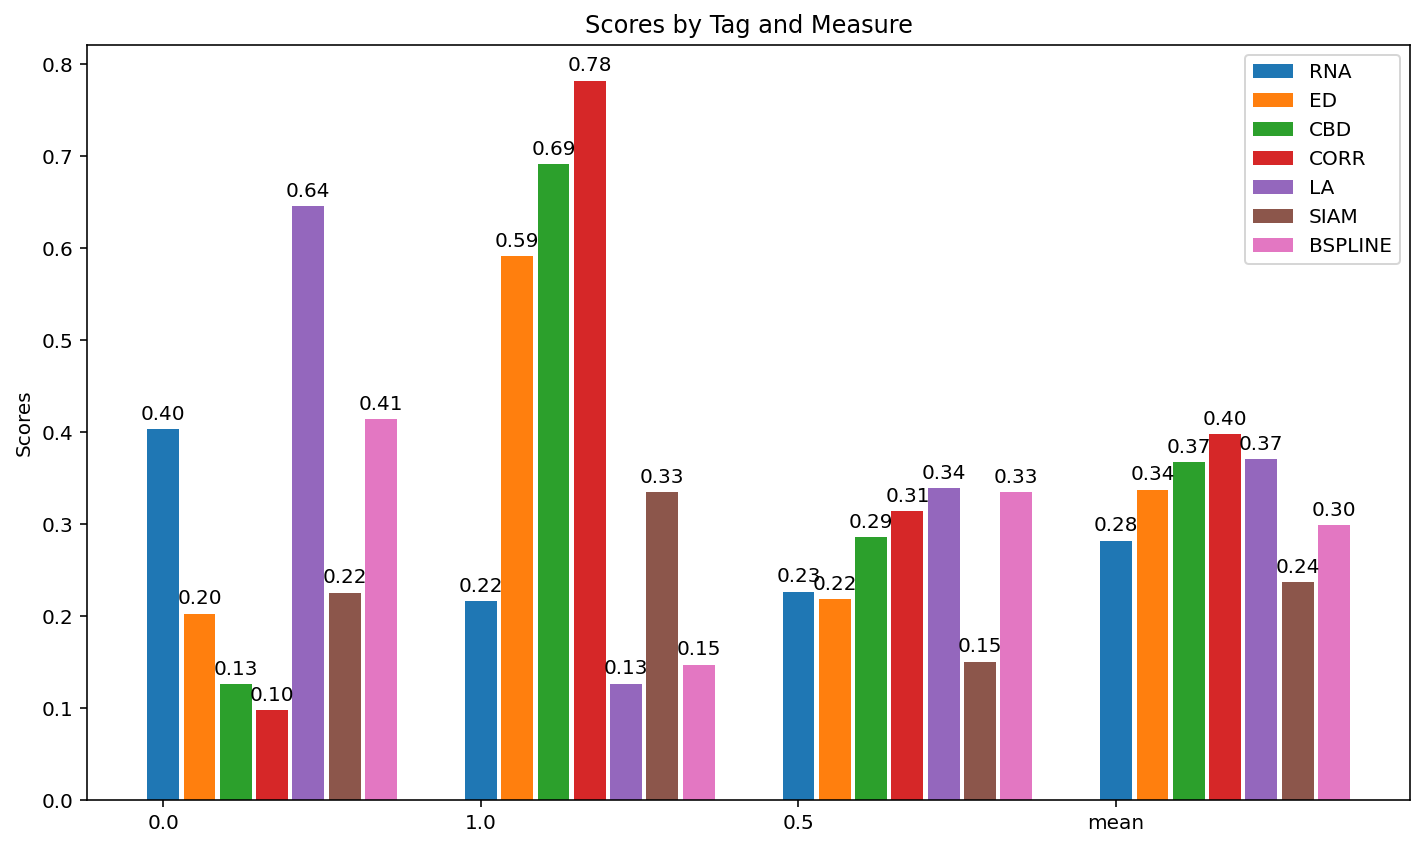

In [87]:
measure_names = list(store_roc_values.keys())
labels = list(store_roc_values[measure_names[0]].keys())
x = np.arange(len(labels))  # the label locations
width = 0.1  # the width of the bars

fig, ax = plt.subplots(figsize=(10,6))

rects = []
cnt_i = 0
for m_name in measure_names:
    
    values_to_plot = []
    for label_i in labels:
        values_to_plot.append(store_roc_values[m_name][label_i])
    
    rects.append(ax.bar(x + ((width/7) * cnt_i) , values_to_plot, width, label=m_name))
    cnt_i += 8

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Scores')
ax.set_title('Scores by Tag and Measure')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()


def autolabel(rects):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{:.2f}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')


for rect_i in rects:
    autolabel(rect_i)


fig.tight_layout()

plt.show()

In [94]:
for m_name in measure_names:
    values_to_plot = []
    for label_i in labels:
        values_to_plot.append("{0:.4f}".format(store_roc_values[m_name][label_i]))
    print("{0}:{1}".format(m_name, values_to_plot))

RNA:['0.4027', '0.2159', '0.2258', '0.2815']
ED:['0.2023', '0.5908', '0.2177', '0.3369']
CBD:['0.1252', '0.6907', '0.2852', '0.3670']
CORR:['0.0972', '0.7815', '0.3134', '0.3974']
LA:['0.6450', '0.1262', '0.3387', '0.3700']
SIAM:['0.2248', '0.3343', '0.1500', '0.2363']
BSPLINE:['0.4136', '0.1465', '0.3344', '0.2981']
